# Goal: working with a smaller subset of Prudential data 

The point is to be able to go through with a workflow on my laptop. 

Data set (59381 rows) is randomly subsetted to a smaller df.

In [2]:
# Imports and magic here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# Globals here

In [4]:
# Read input dataset
input_csv = './train.csv'
df_raw = pd.read_csv(input_csv, index_col = 0)

** Randomly extract 500 rows from df_raw into df_sampled **

In [5]:
# Sample df_raw to create a smaller, easier to work with df
rows = np.random.choice(df_raw.index.values,500)
df_sampled = df_raw.ix[rows]

In [6]:
df_sampled.shape

(500, 127)

In [7]:
# Identify predictor variables and response varibales, and create corresponding DFs

def split_response_from_features(df):
    response = 'Response'
    all_predictors = [col for col in df.columns if col not in response]
    df_predictors = df[all_predictors]
    df_response = df[response]
    df_response_with_dummies = pd.get_dummies(df_response,prefix='Response')
    return df_predictors, df_response, df_response_with_dummies

In [11]:
df_predictors = split_response_from_features(df_sampled)[0]
df_response_with_dummies = split_response_from_features(df_sampled)[2]
df_response = split_response_from_features(df_sampled)[1]

In [9]:
df_sampled.columns

Index([u'Product_Info_1', u'Product_Info_2', u'Product_Info_3',
       u'Product_Info_4', u'Product_Info_5', u'Product_Info_6',
       u'Product_Info_7', u'Ins_Age', u'Ht', u'Wt', 
       ...
       u'Medical_Keyword_40', u'Medical_Keyword_41', u'Medical_Keyword_42',
       u'Medical_Keyword_43', u'Medical_Keyword_44', u'Medical_Keyword_45',
       u'Medical_Keyword_46', u'Medical_Keyword_47', u'Medical_Keyword_48',
       u'Response'],
      dtype='object', length=127)

**Preliminary exploratory plots:**
1. Wt versus BMI (Intuitively one would guess there is a positive correlation).
2. Plot the distribution of Resposne variable to see if there are evenly represented in df_sample. If not we might need to upsample, downsample or generate rows for the underrepresented response by SMOTE.

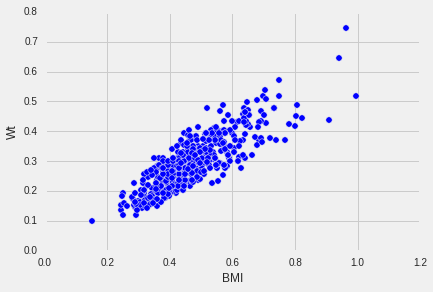

In [14]:
# Plot scatterplot of Wt vs BMI
with plt.style.context('fivethirtyeight'):
    plt.scatter(df_sampled.BMI,df_sampled.Wt,s=40)
    # add axis label
    plt.xlabel('BMI')
    plt.ylabel('Wt')
plt.show()    

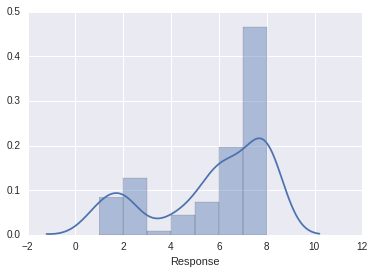

In [15]:
# Plot the distribution of Response
sns.distplot(df_sampled.Response)

In [16]:
response_count = {}
for ii in df_sampled.Response.unique():
    response_count[ii] = len(df_sampled[df_sampled.Response==ii])
    total_num = len(df_sampled[df_sampled.Response==ii])
    print "Total number of Response#{} : {}".format(ii,total_num)
print response_count       

Total number of Response#8 : 159
Total number of Response#2 : 64
Total number of Response#7 : 74
Total number of Response#6 : 98
Total number of Response#1 : 42
Total number of Response#5 : 37
Total number of Response#4 : 22
Total number of Response#3 : 4
{1: 42, 2: 64, 3: 4, 4: 22, 5: 37, 6: 98, 7: 74, 8: 159}


# Notes on the Response column
1. Response 6,8 is roughly 4-5 times higher than the rest of the responses : consider undersampling.
2. Response 3 and 4 are way less than the others: consider oversampling.

In [17]:
# Describe each feature: Number of uniques, number of nulls, type_of_feature, distribution

def get_dummy_features(df, verbose=False, dummy_threshold = 200):
    features_for_dummification = []
    num_rows = len(df)

    for each_feature in df.columns:
        num_uniques = len(df[each_feature].unique())
        num_nulls = df[each_feature].isnull().sum()
        example = df[each_feature].iloc[0]
        
        # Keep track of dummy features
        if isinstance(example, str) or (num_uniques*dummy_threshold<num_rows and isinstance(example, (int, long))): 
            features_for_dummification.append(each_feature)

        if verbose==True:
            print '{}: Uniques: {}/{}. Nulls: {}. Type: {}'.format(each_feature, num_uniques, 
                                                               num_rows, num_nulls, type_of_feature)
            
            
    return features_for_dummification

In [18]:
# check if number of dummiable columns in the original df and the sampled df are the same
print len(get_dummy_features(df_raw,verbose=False,dummy_threshold=200))
print len(get_dummy_features(df_sampled,verbose=False,dummy_threshold=200))

108
93


In [19]:
get_dummy_features(df_predictors)

['Product_Info_1',
 'Product_Info_2',
 'Product_Info_5',
 'Product_Info_6',
 'Product_Info_7',
 'Employment_Info_3',
 'Employment_Info_5',
 'InsuredInfo_2',
 'InsuredInfo_4',
 'InsuredInfo_5',
 'InsuredInfo_6',
 'InsuredInfo_7',
 'Insurance_History_1',
 'Insurance_History_2',
 'Insurance_History_3',
 'Family_Hist_1',
 'Medical_History_3',
 'Medical_History_4',
 'Medical_History_5',
 'Medical_History_6',
 'Medical_History_9',
 'Medical_History_11',
 'Medical_History_12',
 'Medical_History_13',
 'Medical_History_16',
 'Medical_History_17',
 'Medical_History_19',
 'Medical_History_20',
 'Medical_History_21',
 'Medical_History_22',
 'Medical_History_23',
 'Medical_History_26',
 'Medical_History_27',
 'Medical_History_28',
 'Medical_History_29',
 'Medical_History_30',
 'Medical_History_31',
 'Medical_History_33',
 'Medical_History_34',
 'Medical_History_35',
 'Medical_History_37',
 'Medical_History_38',
 'Medical_History_39',
 'Medical_History_40',
 'Medical_History_41',
 'Medical_Keyword_1

**The answer is no: 108 for original df_raw and 94 for df_sampled. But that's ok. Just go ahead with the workflow anyway.**

In [20]:
# Turn chosen features into dummy variables
def create_dummy_features(df, features_for_dummification, verbose=True):
    df_expanded = df

    for each_feature in features_for_dummification:
        if verbose==True:
            print "Expanding variable: {}".format(each_feature)
        df_temp = pd.get_dummies(df[each_feature], prefix=each_feature)
        df_expanded = pd.concat([df_expanded, df_temp], axis = 1, join = 'inner')
        df_expanded.drop(each_feature,inplace=True, axis=1)
        
    return df_expanded

In [21]:
# # Since training data and test data have different distributions for "dummyizable" features, it makes sense to
# # build out dummy features using a combined distribution
df_oos_sneak_peek = pd.read_csv('./test.csv', index_col = 0)
df_predictors_enhanced = pd.concat([df_predictors, df_oos_sneak_peek], axis = 0, join = 'outer')
df_predictors_enhanced.shape

(20265, 126)

In [22]:
# Since Medical_Keyword is already dummied, make sure you exclude it in the dummying process!
features_for_dummification = get_dummy_features(df_predictors)
features_already_dummy = ['Medical_Keyword_{}'.format(num) for num in range(1,49)]
features_for_dummification = sorted(list(set(features_for_dummification) - set(features_already_dummy)))
print features_for_dummification

['Employment_Info_3', 'Employment_Info_5', 'Family_Hist_1', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'InsuredInfo_2', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_16', 'Medical_History_17', 'Medical_History_19', 'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 'Medical_History_3', 'Medical_History_30', 'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 'Medical_History_4', 'Medical_History_40', 'Medical_History_41', 'Medical_History_5', 'Medical_History_6', 'Medical_History_9', 'Product_Info_1', 'Product_Info_2', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7']


In [23]:
# Run the functions from above (df_expanded has dummy variables)
df_sample_expanded_enhanced = create_dummy_features(df_predictors_enhanced,features_for_dummification)
df_expanded = df_sample_expanded_enhanced.drop(df_oos_sneak_peek.index)
df_expanded.shape

Expanding variable: Employment_Info_3
Expanding variable: Employment_Info_5
Expanding variable: Family_Hist_1
Expanding variable: Insurance_History_1
Expanding variable: Insurance_History_2
Expanding variable: Insurance_History_3
Expanding variable: InsuredInfo_2
Expanding variable: InsuredInfo_4
Expanding variable: InsuredInfo_5
Expanding variable: InsuredInfo_6
Expanding variable: InsuredInfo_7
Expanding variable: Medical_History_11
Expanding variable: Medical_History_12
Expanding variable: Medical_History_13
Expanding variable: Medical_History_16
Expanding variable: Medical_History_17
Expanding variable: Medical_History_19
Expanding variable: Medical_History_20
Expanding variable: Medical_History_21
Expanding variable: Medical_History_22
Expanding variable: Medical_History_23
Expanding variable: Medical_History_26
Expanding variable: Medical_History_27
Expanding variable: Medical_History_28
Expanding variable: Medical_History_29
Expanding variable: Medical_History_3
Expanding variab

(500, 205)

** Question about performing correlations: should we test this before making dummies?**

In [24]:
# # Compute pairwise correlations of all predictors
# df_predictors = df_expanded
# df_predictor_correlations = df_predictors.corr()


In [25]:
# # Describe pairwise correlations
# _corr_threshold = 0.5

# for pred in all_predictors:
#     df_temp = df_predictor_correlations[pred]
#     max_corr = df_temp[[idx for idx in df_temp.index if pred not in idx]].max()
#     min_corr = df_temp.min()
#     if np.isnan(max_corr)==False:
#         if abs(min_corr)>max_corr:
#             other_pred = df_temp[df_temp==min_corr].index[0]
#             mcorr = min_corr
#         else:
#             other_pred = df_temp[df_temp==max_corr].index[0]
#             mcorr = max_corr
#         if abs(mcorr)>_corr_threshold:
#             print '** ',
#         print 'mcorr({})={:.4f} with {}'.format(pred, mcorr, other_pred)

# Feature Engineering:
1. Fill NAs for both the predictord and response with median estimates of the column (not localized approach as of now)
    

In [26]:
# Fill NAs with median estimates
df_predictors_selected = df_expanded
df_response_selected = df_response_with_dummies

df_predictors_selected.fillna(df_predictors_selected.median(),inplace=True)
df_response_selected.fillna(df_response_selected.median(),inplace=True)

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:2602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Response_1,Response_2,Response_3,Response_4,Response_5,Response_6,Response_7,Response_8
Id,,,,,,,,
9836,0,0,0,0,0,0,0,1
9121,0,1,0,0,0,0,0,0
3396,0,0,0,0,0,0,1,0
73476,0,1,0,0,0,0,0,0
57135,0,0,0,0,0,1,0,0
31055,1,0,0,0,0,0,0,0
66064,0,0,0,0,1,0,0,0
29641,0,0,0,0,0,0,1,0
32616,0,0,0,0,0,1,0,0


**Notes on Response variable:**
    
When I use all 8 dummy columns for response, I get "bad shape" error below. I will try using just one Response columns(1 through 8) 
and try OnevsRest or some method...

In [ ]:
df_response.isnull().sum()

# Learning curve

The point is to see if we have enough data. We will do this by determining cross-validated training and test scores for different training set sizes. I'm going to give this a shot with Logistic Regression using all features.

In [30]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold, ShuffleSplit 
from sklearn.linear_model import LogisticRegression

In [24]:
# Assign predictors to X and response to Y
X = df_predictors_selected
#y = df_response_selected
y = df_response

In [25]:
print X.shape
print y.shape

(500, 205)
(500,)


In [26]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

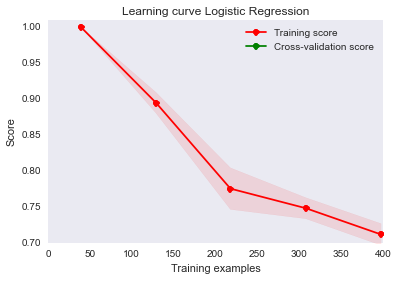

In [27]:
estimator = LogisticRegression()
title = "Learning curve Logistic Regression"
#cv = cross_validation.ShuffleSplit(digits.data.shape[0], n_iter=100,test_size=0.2, random_state=0)
cv=StratifiedKFold(y,n_folds=5,shuffle=True,random_state=1)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

# Model building:

**Make another version of the data where the minority response values are oversampled OR synthetically generated using SMOTE. First use the original dataset and then the altered for each model:[X,y OR X1,y1]**

1. Fit independent models using all features:
    1.1 Logistic Regression
    1.2 Naive Bayes
    1.3 K-Nearest Neighbor



2. Plot learning curve for any (?) model that gives a decent accuracy to see if we have enough data in hand!!



3. Fit ensemble models using all features:
    3.1 RandomForest
    3.2 Gradient Boosting Classifier
    3.3 Voting Classifier (combo of models from Step#1: show that base classifiers are better than a coin toss)
    
 
**Other points to think about:**

1) K-fold cross-validation can be folded into the model: each run will give a score: we can get the median score.


2) Feature selection: We should apply penalty (C which is 1/lambda.. C=0.1 means high penalty. Apply Lasso). Find coefficients and discuss the importance. Look for intuitive explanations. 
2.1) For Logistic Regression and Naive Bayes, we will get probabilities so besides just looking at the median CV score,w ill it be useful to look at the confusion matrix, find TPR, FPR, plot a ROC curve and determine AUC? Is that of interest to Prudential??


3) To simplify the model, if scores aren't awesome, we can even remove features showing multicollinearity by the correlation rule in the book. (Should we be looking at covariance?). Will PCA help in finding out which features are colinear? Because they will be on the same axis.




2-fold cross-validation score: 0.340048967051
3-fold cross-validation score: 0.321212121212
4-fold cross-validation score: 0.333289256198
5-fold cross-validation score: 0.323529411765
6-fold cross-validation score: 0.349668774466
7-fold cross-validation score: 0.347826086957
8-fold cross-validation score: 0.336021505376
9-fold cross-validation score: 0.333333333333
10-fold cross-validation score: 0.343289689034

Best CV score: 0.349668774466


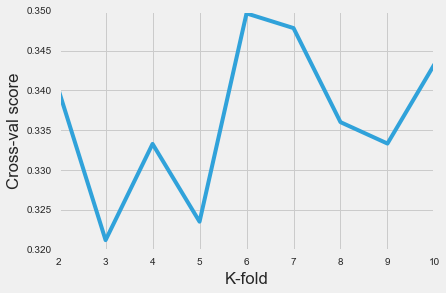

In [34]:
# Fit LOGISTIC REGRESSION model and compute the max cross_validation score over various K-folds.
model_lr = LogisticRegression(penalty = 'l1',C=0.05) # Instantiate Logistic Regression model
scores =[]
jj = 0
for ii in range(2,11):
    scores.append(np.median(cross_val_score(model_lr, X, y, cv=StratifiedKFold(y, ii, shuffle=False))))
    print "{}-fold cross-validation score: {}".format(ii,scores[jj])
    jj += 1
print '\n'"Best CV score: {}".format(max(scores))
with plt.style.context('fivethirtyeight'):
    plt.plot(range(2,11),scores)
    plt.xlabel('K-fold')
    plt.ylabel('Cross-val score')
plt.show()

In [36]:
# find the CV score for 5-fold cross-validation
cv_score_5fold = cross_val_score(model_lr,X,y,cv=5).mean()
cv_score_5fold

0.33377967669417036

In [43]:
# To obtain coefficients of features, we need to do a test train split, fit, predict, score and get coefs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
lr_fitted = model_lr.fit(X_train,y_train)
lr_fitted.score(X_test,y_test)
(lr_fitted.coef_).max()

0.046147321802189605

**Overall Logistic Regression is doing pretty badly above.**

1) I will synthetically upsample (SMOTE) response # 3,4 and downsample response 6,8

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV

X = df_predictors_selected
y = df_response

CV_FOLDS = 2

# Set up grid search
pgrid = {'learning_rate': [0.05, 0.1, 0.5], #'n_estimators': [1, 10, 100, 1000], 
         'subsample': [0.6, 0.75, 0.9],
         'max_depth': [3,7,15]
        }

clf_grdbst = GradientBoostingClassifier(verbose=True)

grid = GridSearchCV(clf_grdbst, param_grid=pgrid, cv = CV_FOLDS)
grid.fit(X, y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1         274.5972           3.2570            3.51s
         2         264.3534           5.6166            3.95s
         3         252.0618           3.2046            3.93s
         4         239.8876           2.8477            3.76s
         5         227.2196           2.3699            3.68s
         6         217.0328           1.7585            3.50s
         7         209.3303           1.7967            3.47s
         8         203.6786           2.2674            3.43s
         9         197.2608           2.3208            3.38s
        10         185.2296           1.6168            3.27s
        20         136.7484           0.8035            2.71s
        30         104.5300           0.1817            2.40s
        40          90.3773          -0.2431            2.04s
        50          76.2004          -0.3084            1.67s
        60          59.9695          -0.3290            1.31s
       

GridSearchCV(cv=2, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0,
              verbose=True, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'subsample': [0.6, 0.75, 0.9], 'learning_rate': [0.05, 0.1, 0.5], 'max_depth': [3, 7, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [32]:
grid.best_estimator_.score()

0.442